> **Can Fortran’s ‘**do concurrent**’ replace directives for accelerated
> computing?*⋆***
>
> Miko M. Stulajter\[0000*−*0003*−*0939*−*1055\], Ronald M.
> Caplan\[0000*−*0002*−*2633*−*4290\] and Jon A.
> Linker\[0000*−*0003*−*1662*−*3328\]

<table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th rowspan="3">arXiv:2110.10151v1 [cs.MS] 18 Oct 2021</th>
<th colspan="2"><blockquote>
<p>Predictive Science Inc. 9990 Mesa Rim Road Suite 170, San Diego, CA
92121 <em>{</em>miko,caplanr,linkerj@predsci.com</p>
<p><strong>Abstract.</strong> Recently, there has been growing interest
in using standard language constructs (e.g. C++’s Parallel Algorithms
and Fortran’s do concurrent) for accelerated computing as an alternative
to directive-based APIs (e.g. OpenMP and OpenACC). These constructs have
the potential to be more portable, and some compilers already (or have
plans to) support such standards. Here, we look at the current
capabilities, portability, and performance of replacing directives with
Fortran’s do concurrent using a mini-app that currently implements
OpenACC for GPU-acceleration and OpenMP for multi-core CPU parallelism.
We re-place as many directives as possible with do concurrent, testing
various configurations and compiler options within three major
compilers: GNU’s gfortran, NVIDIA’s nvfortran, and Intel’s ifort. We
find that with the right compiler versions and flags, many directives
can be replaced with-out loss of performance or portability, and, in the
case of nvfortran, they can all be replaced. We discuss limitations that
may apply to more com-plicated codes and future language additions that
may mitigate them. The software and Singularity containers are publicly
provided to allow the results to be reproduced.</p>
<p><strong>Keywords:</strong> accelerated computing · OpenMP · OpenACC ·
do concur-rent · standard language parallelism.</p>
</blockquote></th>
</tr>
<tr class="odd">
<th><strong>1</strong></th>
<th><blockquote>
<p><strong>Introduction</strong></p>
</blockquote></th>
</tr>
<tr class="header">
<th colspan="2"><blockquote>
<p>OpenMP1[11] and OpenACC2[5] are popular directive-based APIs for
paralleliz-ing code to run on multi-core CPUs and GPUs. For accelerated
computing, they</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> *⋆* Supported by NSF awards AGS 202815 and ICER 1854790, and NASA
> grant 80NSSC20K1582. This work used the Extreme Science and
> Engineering Discovery Environment (XSEDE) Bridges2 at the Pittsburgh
> Supercomputer Center through allocation TG-MCA03S014. It also used the
> DGX A100 system at the Computational Science Research Center at San
> Diego State University provided by NSF award OAC 2019194  
> 1 www.openmp.org  
> 2 www.openacc.org
>
> 2 M. Stulajter, R. M. Caplan, et al.
>
> provide a higher-level approach to accelerating codes without
> requiring writ-ing specialized low-level, often vendor-specific, API
> code (e.g. CUDA, ROCm, OpenCL, etc.). Since they mostly consist of
> specialized comments/pragmas, they exhibit backward compatibility,
> allowing a non-supported compiler to simply ig-nore them and still
> compile the code as before. This makes directive-based ap-proaches
> very desirable for legacy codes, and helps to allow compartmentalized
> development. However, they also can suffer from incomplete vendor,
> hardware, and/or compiler support, make codes somewhat harder to read,
> and, due to their rapid development, are less future-proof than
> standard languages, possibly requiring occasional re-writes.
>
> Due to the widespread adoption of multi-core CPUs and accelerators,
> stan-dard languages have begun to add built-in features that may
> help/enable com-pilers to parallelize code. This includes C++17’s
> Standard Parallel Algorithms and Fortran’s do concurrent (DC) (see
> Refs. \[6,10\] for examples using the NVIDIA HPC SDK3). Standard
> parallel language features have the potential to remove the need for
> directives, making multi-threaded and accelerated codes fully portable
> across compiler vendors and hardware. However, this requires compiler
> support, and few have been quick to implement these features for GPU
> acceleration.
>
> Here, we focus on Fortran’s DC construct. The NVIDIA HPC SDK is the
> only compiler at the time of this writing with accelerator support
> using DC, while Intel has indicated plans to add such support in an
> upcoming release of their ifort compiler included in the OneAPI HPC
> Toolkit\[13\]. Other compilers that support directive-based
> accelerator offloading in Fortran include GCC’s gfortran4, LLVM
> flang5, AOCC’s extended flang6, IBM’s XL7, and HPE’s Cray Fortran8,
> but we could not find any announced plans for these to support DC for
> accelerated computing in the near future.
>
> In this paper, we investigate the current capabilities, portability,
> and perfor-mance of replacing directives with DC in a Fortran mini-app
> that currently implements directives for GPU-acceleration and
> multi-core CPU parallelism. We replace as many directives as possible
> with DC, testing various run-time configurations and compilers. Our
> mini-app currently uses OpenACC with ei-ther nvfortran or gfortran for
> GPU-acceleration on NVIDIA GPUs, and uses OpenMP with nvfortran.
> gfortran, or ifort for multi-core CPU parallelism (as well as OpenACC
> multi-core with nvfortran). A key portability concern is if replacing
> directives with DC for GPU-acceleration will result in a loss of
> multi-core CPU parallelism. Therefore, we test if each compiler can
> parallelize the DC loops for multi-core CPUs. We note that for codes
> using non-hybrid MPI
>
> 3  
> 4  
> 5  
> 6  
> 7  
> 8
>
> Can do concurrent replace directives? 3
>
> for CPU parallelism and MPI+OpenMP/ACC for GPU acceleration, this is
> not as much of a concern.
>
> The paper is organized as follows: In Sec. 2, we describe our Fortran
> mini-app with its current directive-based parallelelization, along
> with the test case we use, showing baseline performance results. In
> Sec. 3, we describe the implementation of DC into the mini-app, first
> introducing its capabilities and support, and then showing examples of
> replacing OpenMP/ACC directives with DC, including a discussion of
> current limitations. Then the resulting mini-app source code ver-sions
> and compiler flag options used for the tests are described.
> Performance and compatibility results are reported in Sec. 4 for both
> multi-core CPU and GPU runs. Finally, discussion on the current status
> of DC and its potential to replace directives is given in Sec. 5.
> Instructions on how to access and use our provided Singularity
> containers and codes to reproduce the results in the paper are given
> in the Appendix.
>
> **2** **Code and test description**
>
> To investigate the current capabilities, portability, and performance
> of replacing directives with DC, we use a Fortran mini-app called
> diffuse that currently im-plements directives for GPU-acceleration and
> multi-core CPU parallelism. Here we describe the code, the test case
> we use, the computational test environment, and baseline performance
> results.
>
> **2.1** **Code description**
>
> NASA and NSF have recently supported a program called ”Next Generation
> Software for Data-driven Models of Space Weather with Quantified
> Uncertain-ties”, whose main objective is to improve predictions of
> solar wind and coronal mass ejections to investigate how they might
> impact Earth. This will be done by developing a new data-driven
> time-dependent model of the Sun’s upper atmo-sphere. One key component
> of this model is the use of a data-assimilation flux transport model
> to generate an ensemble of magnetic field maps of the solar sur-face
> to use as boundary conditions. To accomplish this, we have been
> developing an Open-source Flux Transport (OFT) software suite, whose
> key computational core is the High-Performance Flux Transport code
> (HipFT). HipFT currently implements OpenACC for GPU-acceleration and
> OpenMP for multi-core CPU parallelism, and we are interested in
> replacing the directives with DC.
>
> In order to test the use of DC, we use a mini-app called diffuse that
> imple-ments the most computationally expensive algorithm (surface
> diffusion) of the flux transport in HipFT. diffuse’s source code for
> the diffusion algorithm is identical to that of HipFT. The diffusion
> algorithm integrates a spherical sur-face heat equation on a logically
> rectangular non-uniform grid. The operator is discretized with a
> second-order central finite-difference scheme in space, while the time
> integration uses the second-order Legendre polynomial extended
> sta-bility Runge-Kutta scheme (RKL2) \[8,3\].
>
> 4 M. Stulajter, R. M. Caplan, et al.
>
> **2.2** **Test description**
>
> Although diffuse is used here as a mini-app representation of HipFT,
> it is also used in production to slightly smooth solar surface
> magnetic fields to prepare them for use in models of the corona \[2\].
> As such, we select a real-world exam-ple of using diffuse, that of
> smoothing the ‘Native res PSI map‘ described in Ref. \[4\]. This large
> map has a resolution of 3974*×*2013 in (*θ, φ*) and takes 40,260 total
> iterations of applying the diffusion operator to smooth. A detail from
> the map before and after running diffuse is shown in Fig. 1.

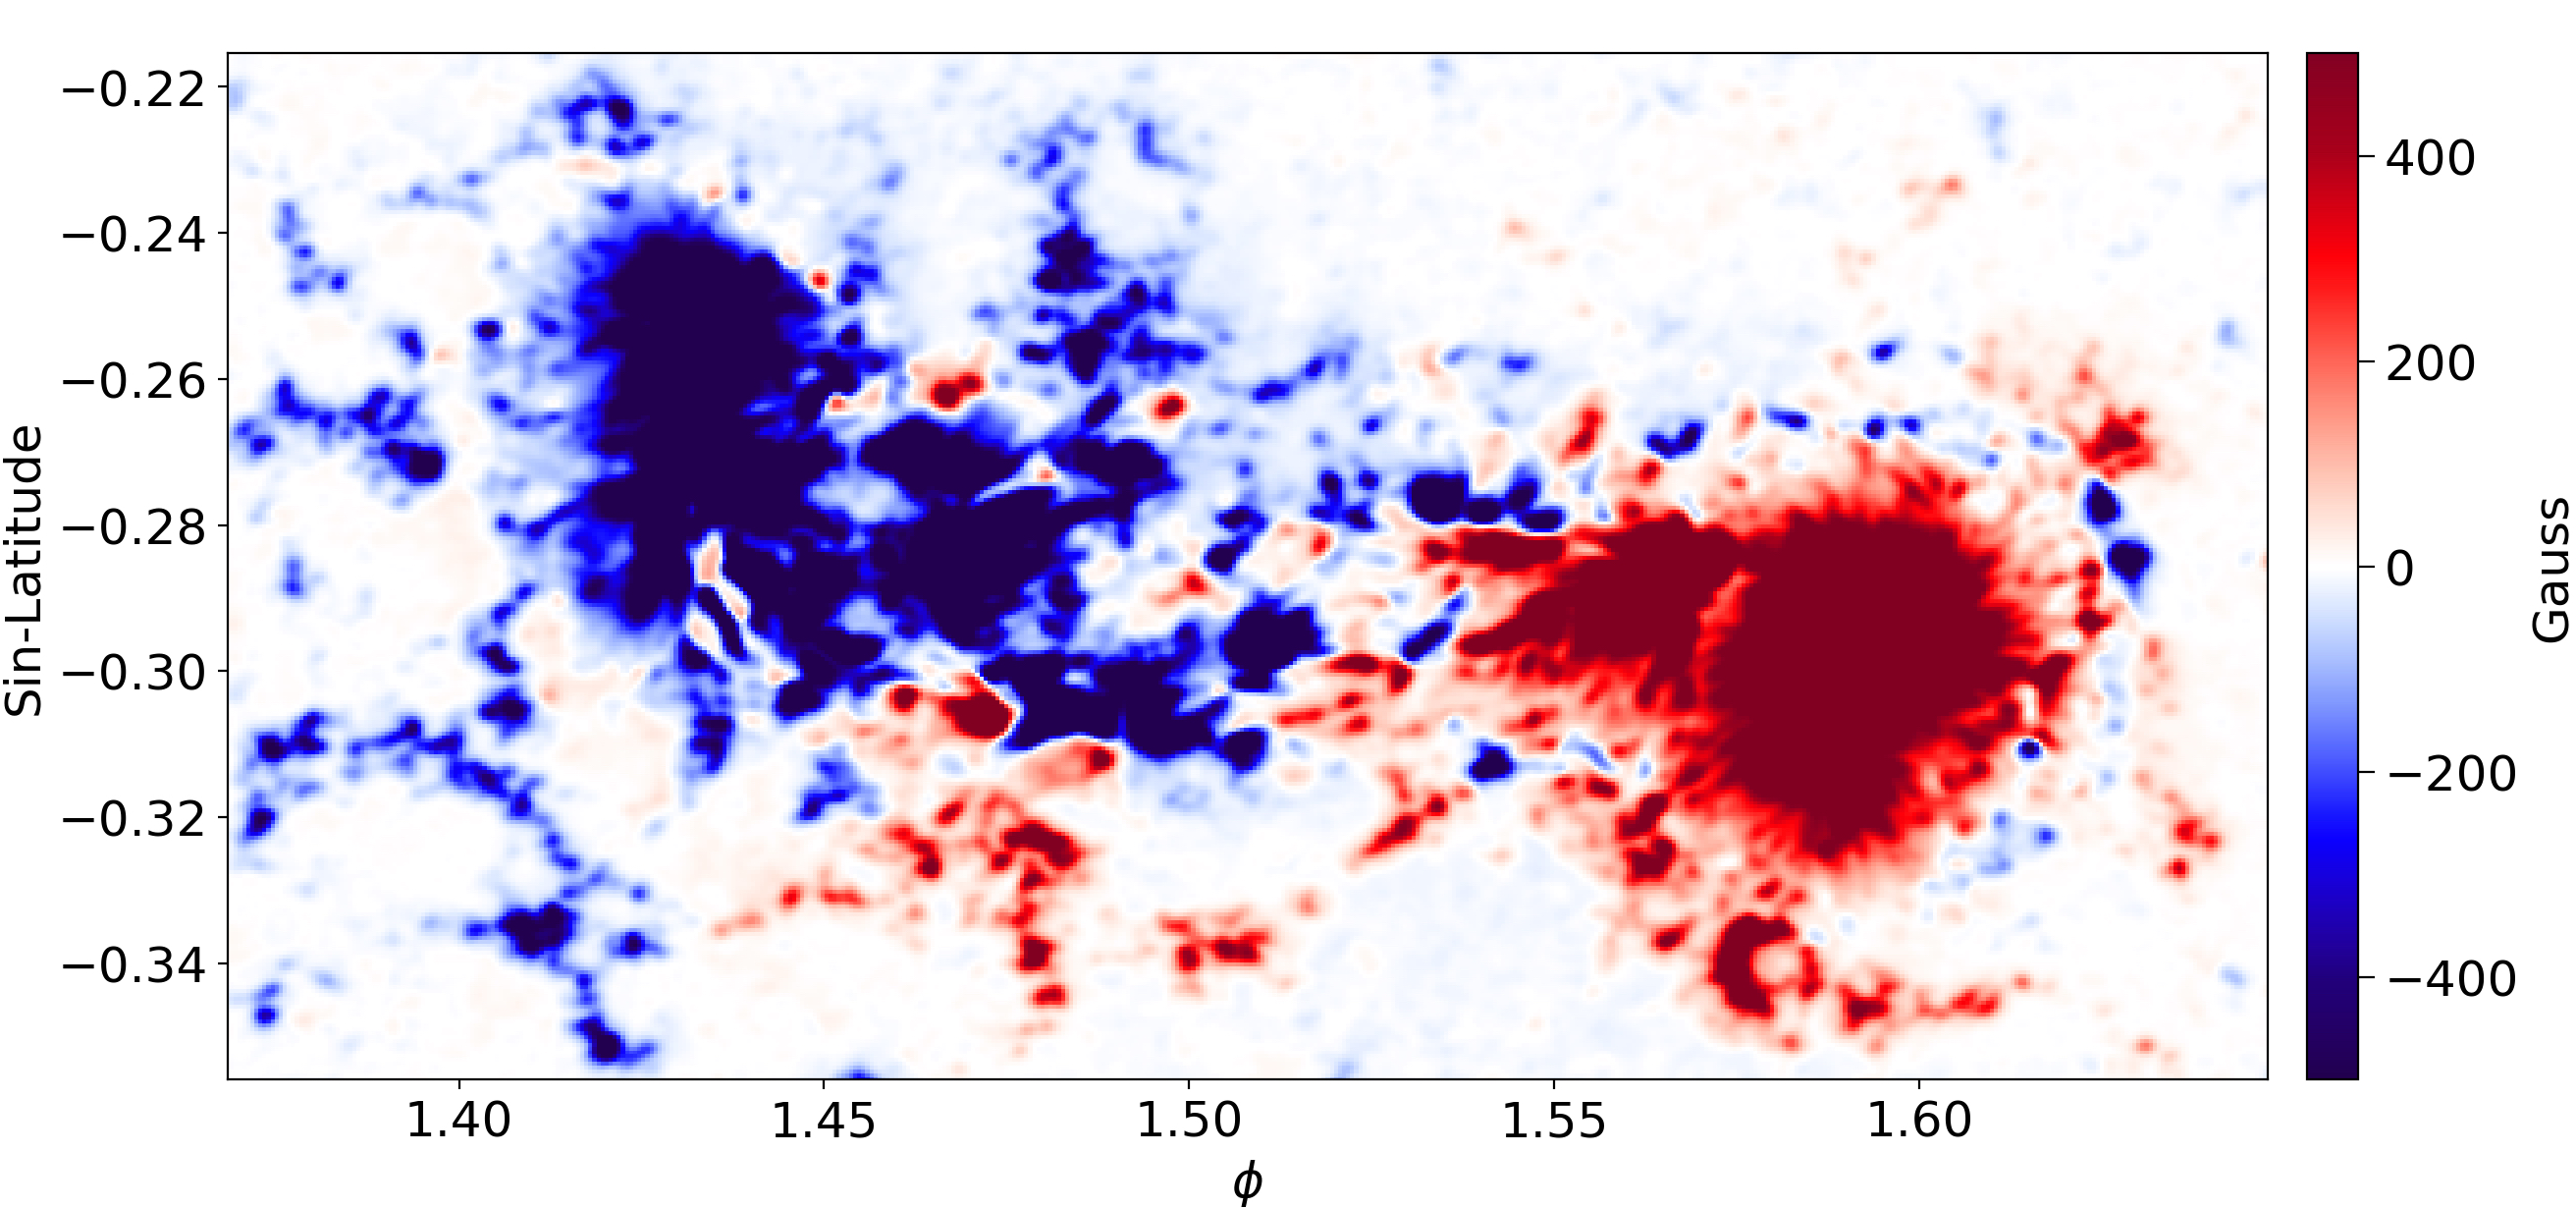

> <img
> src="attachment:vertopal_3ec4073fc0c540e6bdade8c9ff1958a1/media/image2.png"
> style="width:2.35278in;height:1.10417in" />
>
> **Fig. 1.** Zoomed-in detail of the test case magnetic field map
> before (left) and after (right) smoothing with diffuse.
>
> **2.3** **Computational environment**
>
> In order to best assess the capabilities of the compiler support for
> DC, we use the latest available versions of the compilers at the time
> of testing. These are shown in Table 1. The CPU tests are run on the
> Bridges2 system located at

**Table 1.** Compiler versions used in tests.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Compiler Suite</th>
<th>Compiler</th>
<th>Version</th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><blockquote>
<p>GNU Compiler Collection NVIDIA HPC SDK<br />
Intel OneAPI HPC Toolkit</p>
</blockquote></td>
<td><blockquote>
<p>gfortran<br />
nvfortran<br />
ifort (classic)</p>
</blockquote></td>
<td><blockquote>
<p>11.2<br />
21.7<br />
21.3</p>
</blockquote></td>
<td></td>
</tr>
</tbody>
</table>

> the Pittsburgh Supercomputing Center using our allocation obtained
> through NSF’s XSEDE program\[12\]. The GPU tests are run on an NVIDIA
> DGX A100 server at San Diego State University. Since diffuse does not
> have multi-node or multi-GPU capabilities, the CPU tests are run on a
> single CPU node, while the GPU tests are run on a single GPU within
> the DGX system. The hardware specifications are shown in Table 2.
>
> Since systems do not always have the latest compilers available, and
> setting up our code’s dependencies can be difficult, we utilize
> Singularity containers\[7\].
>
> Can do concurrent replace directives? 5

**Table 2.** Hardware utilized for all test runs.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th></th>
<th>CPU</th>
<th>GPU</th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><blockquote>
<p>CPU/GPU Model</p>
<p>Peak Memory Bandwidth<br />
Clock Frequency (base/boost) RAM<br />
Peak DP FLOPs</p>
</blockquote></td>
<td><blockquote>
<p>(2x) AMD EPYC 7742 (128 cores)<br />
381.4 GB/s<br />
2.3/3.4 GHz<br />
256 GB<br />
7.0 TFLOPs</p>
</blockquote></td>
<td><blockquote>
<p>NVIDIA A100 SXM4<br />
1555 GB/s<br />
1.1/1.4 GHz<br />
40 GB<br />
9.8 TFLOPs</p>
</blockquote></td>
<td></td>
</tr>
</tbody>
</table>

> These containers are built with the compiler environment and our
> dependent libraries pre-installed so they can be easily used to build
> and run the code. We use Singularity 3.8.0, and for GPU runs, use the
> ‘--nv’ flag to connect to the NVIDIA driver (and CUDA library) on the
> local system. The CUDA run-time library used for GPU runs was version
> 11.4. As shown in the Appendix, running the codes in the containers
> yields virtually the same performance as a bare metal installation.
> All the test runs performed in this paper can be reproduced using the
> containers along with the code, both of which are publicly released in
> Ref. \[9\] and at www.predsci.com/papers/dc.
>
> **2.4** **Baseline performance results**
>
> Our goal in this paper is to test replacing directives with DC for
> accelerated computing, ensuring we do not lose multi-core CPU
> parallelism, and that the performance is comparable to the original
> directive-based code. It is not our focus to compare performance
> between the various compilers and hardware. We therefore use similar
> basic compiler optimization flags (shown in Sec.3.2) for each
> compiler-hardware combination and do not explore all possible
> optimizations. In order to compare the performance of the original
> code to the modified versions, we perform baseline timings of the
> original code. For these, and all timing re-sults in the paper, we run
> each test 10 times and take the average of the full wall clock times
> (which include all I/O and GPU-CPU data transfer time). In Fig. 2 we
> show the baseline timings along with their standard deviations. We
> also include CPU runs on a single CPU core (serial) to illustrate the
> multi-core CPU parallelism. We see that each compiler obtains
> comparable performance on the CPU runs, yielding a speedup of *∼* 7*×*
> when using 128 CPU cores compared to running in serial. While this may
> seem low, it is common for highly memory-bound algorithms to exhibit
> such non-ideal single node multi-threaded scaling \[1\]. The
> performance of the nvfortran CPU run using OpenMP is *∼* 10% faster
> than using OpenACC for multi-core parallelism. On the GPU, the
> nvfortran OpenACC GPU run is *∼* 30% faster than the gfortran run,
> which is not unex-pected considering nvfortran has a more mature
> implementation of OpenACC.
>
> Can do concurrent replace directives? 7
>
> ellipses. With nested loops, there is more of a difference in
> formatting. Code 1 shows nested do loops parallelized with directives.
> The loop nest is shown with both OpenMP and OpenACC directives in the
> manner they are used in the mini-app. This nested do loop example
> spans 8 lines with directives, but can be written in 3 lines with DC
> as shown in Code 2. With DC loops, nested loops initialization
> statements are collapsed into one initialization statement. The syntax
> of DC loops is as follows: do concurrent (index1=start1:end1,
> index2=start2:end2, ...). As this example shows, DC loops make nested
> do loops more compact and easier to read.
>
> **Code 1** Nested do loops with OpenMP/ACC directives !\$omp parallel
> do collapse(2) default(shared)  
> !\$acc parallel loop collapse(2) default(present)  
> **do** i=1,N  
> **do** j=1,M  
> Computation  
> **enddo**  
> **enddo**  
> !\$acc end parallel loop  
> !\$omp end parallel do
>
> **Code 2** Nested do loops as a do concurrent loop
>
> **do concurrent** (i=1:N, j=1:M)  
> Computation  
> **enddo**
>
> Most current compilers support the Fortran 2008 standard, which
> includes the basic DC syntax. However, since the specification does
> not require that the compiler try to parallelize the loops, they are
> often treated as serial do loops. When a compiler does support
> parallelization of DC, special compiler flags are needed to activate
> the feature (see Sec. 3.3 for details).
>
> Although the latest version of the OpenACC (3.1)12specification adds
> sup-port for decorating DC loops with directives, at present, there
> are no imple-mentations of this support (with the possible exception
> of using the kernels directive). There is also no mention of
> supporting directives on a DC construct within the most recent OpenMP
> (5.1)13specification. Therefore, replacing do loops with DC may break
> the ability to parallelize the loops when using compil-ers that do not
> support direct DC parallelization.
>
> 12  
> 13
>
> 8 M. Stulajter, R. M. Caplan, et al.
>
> The current state of DC support is varied across different compilers
> and versions. nvfortran 18.1 added serial support for DC along with
> locality of variables, while nvfortran 20.11 added support for
> parallelization of DC loops for both CPUs and GPUs. In gfortran 8,
> serial support for DC was introduced, while gfortran 9 added support
> for parallelization of DC on multi-core CPUs using gfortran’s auto
> parallelization feature. ifort started supporting serial DC loops in
> version 12. Then, in version 16, parallelization support was added
> through ifort’s auto parallelization feature (using the flag
> -parallel). With version 19.1, locality of variable support was added,
> and parallelization became linked to the OpenMP compiler flags. Table
> 3 gives a summary of the current support of parallel DC loops for the
> compilers used in this paper.
>
> **Table 3.** Current support of DC loop parallelization for the
> compilers used in this paper.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Compiler</th>
<th>Version</th>
<th>do concurrent parallelization support</th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td>gfortran</td>
<td><em>≥</em> 9</td>
<td><blockquote>
<p>Parallelizable on CPU with<br />
-ftree-parallelize-loops=&lt;N&gt;<br />
flag. Locality of variables is <em>not</em> supported.</p>
</blockquote></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td>nvfortran</td>
<td><em>≥</em> 20<em>.</em>11</td>
<td><blockquote>
<p>Parallelizable on CPU and GPU with the -stdpar flag. Locality of
variables is supported.</p>
</blockquote></td>
<td></td>
</tr>
<tr class="odd">
<td></td>
<td>ifort</td>
<td><em>≥</em> 19<em>.</em>1</td>
<td><blockquote>
<p>Parallelizable on CPU with the -fopenmp flag. Locality of variables
is supported.</p>
</blockquote></td>
<td></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="header">
<th><strong>3.2</strong></th>
<th><blockquote>
<p><strong>Code Versions</strong></p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Here we list the code variants that we use to test the portability and
> performance of replacing directives with DC in diffuse. For versions
> that use DC, only basic DC loop syntax was used with no locality of
> variables, as not all compilers support this feature in all
> configurations.
>
> *Original*: This is the original version of diffuse which uses OpenACC
> and OpenMP directives on all parallelizable do loops as well as
> OpenACC data move-ment directives. It does not contain any DC loops.
> It is the code version used for the performance results of Sec. 2.4,
> and will be the standard we compare to for both performance and
> compatibility.
>
> *New*: This version is obtained by replacing directive surrounded do
> loops in *Original* with DC loops, with the exception of reduction
> loops. The directives on the reduction loops are kept since reductions
> are not supported in parallelized DC loops (see discussion in
> *Experimental*). We also keep all OpenACC data directives for explicit
> GPU data management. This code is expected to perform as well as the
> *Original* code if the DC loops are recognized and implemented
> efficiently.
>
> *Serial*: This version contains no OpenACC or OpenMP directives at
> all, nor any DC loops. It is the same as *Original* with all
> directives removed. It should run in serial in all cases, unless an
> auto-parallelizing feature of a compiler is
>
> Can do concurrent replace directives? 9
>
> utilized. We include this code as a control and to ensure the
> multi-core CPU parallel runs are exhibiting the expected parallelism.
>
> *Experimental*: This version does not contain any OpenMP or OpenACC
> di-rectives at all, replacing all loops (including reduction loops)
> with DC. A key feature of this code version is that it represents the
> ‘ideal’ scenario of using only the Fortran standard language for
> accelerated computing without needing any directives. This version
> does not technically violate the Fortran standard since a DC on a
> reduction loop is valid if not parallelized, as the iterations can be
> computed in any order. However, if the compiler does parallelize these
> DC re-duction loops, it will likely produce wrong results due to race
> conditions, unless it supports implicit analysis and implementation of
> DC reductions. As men-tioned above, Fortran 202X will add reductions
> to DC, resolving this problem. Removing all directives also removes
> explicit GPU-CPU data movement, whose absence will lead to very poor
> performance on accelerators (due to repeated data movement between the
> CPU and GPU) unless the compiler supports automatic GPU-CPU memory
> management. Features such as NVIDIA’s Unified Memory and AMD’s Smart
> Access Memory can allow compilers to resolve this issue. In Table 4 we
> summarize all versions of the code we use for our tests.
>
> **Table 4.** Summary of DC and directive implementations for each
> version of the diffuse code tested.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th></th>
<th>do concurrent</th>
<th>Directives</th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Original</em><br />
<em>New</em><br />
<em>Serial</em><br />
<em>Experimental</em></td>
<td>None<br />
all loops except reductions None<br />
all loops</td>
<td>all loops &amp; data management<br />
reduction loops &amp; data management None<br />
None</td>
<td></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="header">
<th><strong>3.3</strong></th>
<th><blockquote>
<p><strong>Compiler Flag Options</strong></p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> The gfortran, nvfortran, and ifort compilers each have different flags
> to im-plement code parallelization and optimizations. Here we describe
> the compiler flags we use for each code version, compiler, and target
> hardware configuration. For all compilers, we use the -O3 flag to
> activate typical compiler optimiza-tions, and -march=\<ARCH\> to tell
> the compiler to target the specific CPU we run the tests on.
> Typically, we use native for \<ARCH\> to automatically target the
> current system, but some configurations (such as using ifort on AMD
> EPYC CPUs) required us to specify the option manually (in that case
> \<ARCH\> is set to core-avx2). All *Serial* code versions use only
> these default compiler flags.
>
> nvfortran: For GPU parallelization, the *Original* code uses the flag
> -acc=gpu which enables the OpenACC directives. We also include the
> flag -gpu=ccXY, cudaX.Y to specify the specific GPU run time and
> hardware capabilities (similar to -march for CPUs). The ccXY indicates
> a device with compute capabilities of X.Y, while cudaX.Y tells the
> compiler to use the X.Y version of the CUDA li-brary. To check if/how
> the compiler parallelized the loops, we set -Minfo=accel, which
> outputs parallelization information.
>
> 10 M. Stulajter, R. M. Caplan, et al.
>
> For the *New* code (containing DC loops), we add two new flags. The
> first is -stdpar=gpu, which enables DC loops to be parallelized and
> offloaded to the GPU14. The other is -Minfo=stdpar which outputs the
> compiler’s parallelization messages (similar to -Minfo=accel). When
> using -stdpar=gpu, unified managed memory is automatically enabled,
> making all allocatable arrays unified arrays. This means the runtime
> is responsible for correct and efficient CPU-GPU data transfers during
> the run, and any OpenACC data movement directives on such arrays are
> essentially no-ops. Static arrays are not made into unified arrays, so
> manual GPU data movement is still needed for good performance (note
> that diffuse does not make use of any static arrays). If one wants to
> continue to manage the GPU data manually (using OpenACC or OpenMP data
> movement directives), the option -gpu=nomanaged can be used.
>
> For the *Experimental* code, since there are no directives, we simply
> use the standard parallelism option of -stdpar=gpu -gpu=ccXY,cudaX.Y,
> and rely on the compiler to automatically detect the reductions and
> implement them cor-rectly, as well as manage the GPU memory using
> unified memory.
>
> For CPU parallelization, the *Original* code has two implementations.
> One is to use OpenMP with the -mp flag, and the other is to use
> OpenACC with the-acc=multicore flag. Even though the OpenMP
> compilation produces slightly better performance (as was shown in Sec.
> 2.4), we only use the OpenACC multi-core option. This is because
> nvfortran currently activates OpenACC when us-ing -stdpar, so we
> cannot use both -stdpar for DC and OpenMP (as would be needed in the
> *New* code) since OpenMP and OpenACC are not written to work together
> (and in the *New* code case, causes a compiler error). We note that
> when using OpenACC for multi-core CPU, the number of threads is
> con-trolled through the runtime variable ACC NUM CORES=\<N\>, rather
> than OpenMP’s OMP NUM THREADS=\<N\>.
>
> For the *Experimental* code, since there are no directives, we simply
> use the standard parallelism option of -stdpar=multicore, relying on
> the compiler to automatically detect the reductions and implement them
> correctly.
>
> gfortran: For GPU parallelization, the *Original* code uses the flag
> -fopenacc, which enables OpenACC directives. In addition to this flag,
> the intended offload GPU must be specified. For NVIDIA GPUs, the flag
> -foffload=nvptx-none is used (targeting specific compute capabilities
> is not currently implemented). We also use the flag
> -fopenacc-dim=\<DIM\> to specify the parallel topology for the offload
> kernels. \<DIM\> is set to three colon-separated values that map to
> ’gang’,’worker’ and, ’vector’ sizes. Since OpenACC supports
> acceleration for multiple GPU vendors, the default values for the
> topology may not be optimal. Although this level of optimization is
> outside the scope of this paper, we observed that the nvfortran
> compiler was using a vector length of 128 when compiling most OpenACC
> loops, so as a simple optimization, we use -fopenacc-dim=::128 for
>
> 14 For nvfortran 21.7, it appears that setting the -stdpar=gpu flag
> implicitly sets the-acc=gpu option as well. This is an important
> consideration if one has OpenACC directives that should be ignored
> when using -stdpar.
>
> Can do concurrent replace directives? 11
>
> our tests. The *New* code is not supported on the GPU with gfortran at
> this time. This is because there is no current support for DC GPU
> offloading.
>
> On the CPU, the *Original* code uses -fopenmp, which as above,
> activates OpenMP directives for multi-core CPU parallelism. gfortran
> does not sup-port direct parallelism on DC loops. Therefore, for the
> *New* code, we must use gfortran’s auto parallelization feature using
> the -ftree-parallelize-loops=\<N\> flag, where \<N\> is the number of
> threads to run on. This auto parallelization an-alyzes both do and DC
> loops and determines if they can be parallelized and if so, implements
> the parallelism. Therefore, it can be used in the case of the *New*
> code, as well as the *Experimental* code. Since the compiler is
> auto-analyzing the loops, it may detect the DC reduction loops and
> parallelize them correctly.
>
> ifort: Since ifort does not currently support GPU-offloading with DC
> or OpenACC, we only test it with CPU parallelism to ensure switching
> from di-rectives to DC does not lose our CPU parallel capabilities
> when using ifort.
>
> For all code versions, we add the flags -fp-model precise and
> -heap-arrays as those are standard flags we use for runs of diffuse to
> ensure robustness and precision, but they are not related to
> parallelization. For the *Original* code, we use the flag -fopenmp in
> order to enable OpenMP directives to produce parallel code for
> multicore CPUs. For the *New* code, we use the same -fopenmp flag as
> the *Original* code, as it is also used to enable automatic
> parallelization of DC loops. The *Experimental* code also uses the
> same -fopenmp flag. However, as the documentation states that DC
> reduction loops are not supported, we do not expect ifort to
> parallelize them, and rather run them in serial (although as will be
> shown, the current compiler version parallelizes the loops anyways,
> resulting in incorrect results).
>
> **4** **Results**
>
> Here we show timing results for all chosen compilers, code versions,
> and hard-ware (where supported). Key questions we address are: 1) do
> the compilers that support GPU-acceleration with directives also
> support it using DC? 2) does replacing directives with DC lose CPU
> multicore parallelism? (i.e. do the com-pilers support DC for CPU
> multicore?) 3) for compiler-hardware combinations that support
> parallelizing DC, how does the performance compare to the base-line
> directive-based code? We first report results for the *New* code
> compared to the *Original* code for each compiler and hardware type,
> and afterwards discuss results for the *Experimental* code.
>
> For each configuration, we run the test case of Sec. 2.2, and use the
> Linux program time to record three times: real, user, and system. The
> real time is the wall clock time the code took to run. The user time
> is the sum of all thread times, or how much total CPU computation time
> was spent. Using multiple threads should result in a lower real time,
> but a (much) higher user time. The system time is the operating system
> overhead, which can include CPU-GPU data transfer, as well as other
> overheads. All reported timings are averaged over 10 runs.
>
> 12 M. Stulajter, R. M. Caplan, et al.
>
> **4.1** **Results using** nvfortran
>
> The results for the *Original* and *New* code run on the GPU with
> nvfortran are shown in Table 5. The time difference between the
> *Original* code and the *New*
>
> **Table 5.** GPU timing results with nvfortran. Both runs used the
> additional compiler flag -gpu=cc80,cuda11.4

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>Compiler flags</th>
<th><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>real (s)</th>
<th><blockquote>
<p>user (s)</p>
</blockquote></th>
<th><blockquote>
<p>system (s)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Original</em></td>
<td>-acc=gpu</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>35.07</th>
<th>34.46</th>
<th>0.59</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><em>New</em></td>
<td>-acc=gpu -stdpar=gp</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>35.67</th>
<th>35.01</th>
<th>0.54</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

| code is less than 2%, and the standard deviation over the 10 runs is around *±*0*.*1*s* for both. The slight increase in run time for the *New* code is possibly due to its |
|------------------------------------------------------------------------|

> use of unified memory, which can be less efficient than manually
> managing the GPU-CPU memory as is done through OpenACC data directives
> in the *Original* code. This result does not achieve a full
> replacement of directives with DC since not all directives were
> replaced in the *New* code. However, the vast majority of them were,
> with only a few remaining directives on the reduction loops, showing
> great progress in replacing directives.
>
> To ensure that we did not loose CPU multicore parallelism, we show the
> CPU results in Table 6. We see that, like in the GPU case, replacing
> directives with

**Table 6.** CPU timing results with nvfortran

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>Compiler flags</th>
<th><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>real (s)</th>
<th><blockquote>
<p>user (s)</p>
</blockquote></th>
<th><blockquote>
<p>system (s)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Serial</em></td>
<td></td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>1284.59</th>
<th><blockquote>
<p>1272.45</p>
</blockquote></th>
<th>0.22</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><em>Original</em></td>
<td>-acc=multicore</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>224.18</th>
<th>26214.96</th>
<th><blockquote>
<p>1965.06</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="odd">
<td></td>
<td><em>New</em></td>
<td>-acc=multicore<br />
-stdpar=multicore</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>219.57</th>
<th>25638.37</th>
<th><blockquote>
<p>1889.20</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

> DC yields similar runtimes to the original code. Here, the *New* code
> with DC runs around 3% faster than the *Original* code, but both are
> within the standard deviation (*±*15*s*) of the 10 runs. Therefore,
> there is no loss of CPU portability when using DC with nvfortran for
> our mini-app.
>
> **4.2** **Results using** gfortran
>
> The result for the *Original* code run on the GPU with gfortran is
> shown in Table 5. Unlike nvfortran, gfortran does not support
> GPU-acceleration using

**Table 7.** GPU timing results with gfortran.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>Compiler flags</th>
<th><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>real (s)</th>
<th>user (s)</th>
<th><blockquote>
<p>system (s)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Original</em></td>
<td><blockquote>
<p>-fopenacc<br />
-foffload=nvptx-none-fopenacc-dim=::128</p>
</blockquote></td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>49.52</th>
<th>48.90</th>
<th>0.54</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><em>New</em></td>
<td>No Support</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>-</th>
<th>-</th>
<th>-</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

> Can do concurrent replace directives? 13
>
> DC, nor is there auto parallelization support for GPU offloading.
> Therefore, replacing the directives with DC currently breaks support
> for GPU-acceleration with gfortran. For NVIDIA GPUs, this is not a
> prohibitive limitation since the nvfortran compiler is freely
> available. However, for other accelerators (namely AMD GPUs), this
> loss of support may rule out using DC at this time.
>
> Unlike for GPU-acceleration, CPU multi-core parallelism with gfortran
> is not lost with DC, even though there is no direct support for DC
> parallelization. In Table 8, we show the CPU timing results of the
> *Original* and *New* codes. We see that the performance difference
> between the codes is *∼* 10%, within the **Table 8.** CPU timing
> results with gfortran

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>Compiler flags</th>
<th><blockquote>
<p>real (s) user (s) system (s)</p>
</blockquote></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Serial</em></td>
<td></td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>1308.75</th>
<th><blockquote>
<p>1296.74</p>
</blockquote></th>
<th>0.16</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><em>Original</em></td>
<td>-fopenmp</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>191.90</th>
<th><blockquote>
<p>24117.72</p>
</blockquote></th>
<th>8.02</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="odd">
<td></td>
<td><em>New</em></td>
<td>-fopenmp<br />
-ftree-parallelize-loops=128</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>212.64</th>
<th><blockquote>
<p>26588.59</p>
</blockquote></th>
<th>8.65</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

| standard deviations of the 10 runs (*±*13*s* for the *Original* and *±*18*s* for the *New* code). The *New* code is also able to be parallelized because gfortran treats DC |
|------------------------------------------------------------------------|

> loops as regular do loops, which are parallelized using the auto
> parallelization feature. However, the loops in diffuse are fairly
> simple. In other codes, the auto parallelization may not be able to
> handle more complex loops, that could otherwise be parallelized using
> directives. Therefore, the result here should be viewed with caution.
> Note also that the auto parallelization feature works the same on our
> code with regular do loops as it does with DC loops (i.e. it would
> even parallelize the *Serial* code version).
>
> The thread control for the *New* code is unique. Since the OpenMP
> direc-tives are still on the reduction loops, while the remaining
> loops use DC with no directives, the number of CPU threads used for
> the reductions is set by the stan-dard OMP NUM THREADS environment
> variable, while that used by the DC loops is controlled by the
> compiler flag value -ftree-parallelize-loops=\<N\>. This complicates
> the thread control, and also removes run-time thread control.
>
> **4.3** **Results using** ifort
>
> As mentioned in the introduction, the Intel OpenAPI Toolkit does not
> currently support GPU-acceleration using DC loops, but there are plans
> for support in the future. Therefore, here we focus on DC
> compatibility with multi-core CPU parallelism. In Table 9, we show the
> timing results for the *Original* and *New* codes. We see that
> replacing directives with DC still allows for multi-core CPU
> parallelism, and surprisingly exhibits a nearly 10% improvement in
> performance. The standard deviation of the 10 runs was roughly
> *±*8*s*, so this performance increase is significant. It may be
> attributed to more efficient optimizations being available to the
> compiler when using DC compared to OpenMP directives.
>
> Since the implementation of DC parallelism is connected to OpenMP (as
> indicated by the use of the -fopenmp flag), the number of threads
> remains con-
>
> 14 M. Stulajter, R. M. Caplan, et al.  
> **Table 9.** CPU timing results with ifort.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>Compiler flags</th>
<th><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>real (s)</th>
<th>user (s)</th>
<th><blockquote>
<p>system (s)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Serial</em></td>
<td></td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>1318.60</th>
<th><blockquote>
<p>1306.27</p>
</blockquote></th>
<th>0.18</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><em>Original</em></td>
<td>-fopenmp</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>194.86</th>
<th>24213.11</th>
<th>320.53</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="odd">
<td></td>
<td><em>New</em></td>
<td>-fopenmp</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>178.29</th>
<th>21888.21</th>
<th>280.65</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

> trolled by the standard environment variable OMP NUM THREADS (or
> optionally at compile time with -par-num-threads=\<N\> which overrides
> OMP NUM THREADS).
>
> **4.4** **Experimental Results**
>
> As mentioned in Sec. 3.2, the current Fortran standard does not have a
> way to indicate to the compiler that a DC loop requires reduction or
> atomic operations. However some compilers have implemented code
> analysis methods to automati-cally detect and implement such
> operations. Therefore, the *Experimental* code, which represents the
> ideal scenario of replacing all directives with DC loops, may work
> with some compilers.
>
> Using nvfortran, we found that the code parallelized and ran correctly
> on both the GPU and CPU. It appears nvfortran detects the reductions
> and im-plements them correctly for our code. The run times are shown
> in Table 10. They

**Table 10.** GPU and CPU timing results for the *Experimental* code
with nvfortran.

<table style="width:100%;">
<colgroup>
<col style="width: 16%" />
<col style="width: 16%" />
<col style="width: 16%" />
<col style="width: 16%" />
<col style="width: 16%" />
<col style="width: 16%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>CPU/GPU</th>
<th>Compiler flag</th>
<th><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>real (s)</th>
<th>user (s)</th>
<th><blockquote>
<p>system (s)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Experimental</em></td>
<td>GPU</td>
<td>-stdpar=gpu<br />
-gpu=cc80,cuda11.4</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>35.63</th>
<th><blockquote>
<p>35.01</p>
</blockquote></th>
<th>0.53</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><em>Experimental</em></td>
<td>CPU</td>
<td>-stdpar=multicore</td>
<td><blockquote>
<p>219.21 25654.35 1906.40</p>
</blockquote></td>
<td></td>
</tr>
</tbody>
</table>

> are nearly identical to those of the *New* code shown in Tables 5 and
> 6 which is expected since only a few small loops used directives for
> reductions in the *New* code. This means that for diffuse, we can use
> DC to fully eliminate all direc-tives and not lose any CPU or GPU
> performance with nvfortran. We reiterate that more complicated codes
> may not yet work with zero directives for a variety of reasons
> including not detecting complicated reduction or atomic operations,
> not being compatible with in-lined function calls, and, for
> GPU-acceleration, not supporting automatic memory management with
> static arrays.
>
> For gfortran, we only test the code on the CPU since there is no
> support for DC GPU-offloading. In this case, the *Experimental* code
> ran correctly, implying the auto-parallelization done by the compiler
> was able to detect the reductions and parallelize them. The run time
> is shown in Table 11 and is roughly 10% slower comparable to the run
> time of the *New* code in Table 8. However, the times are nearly
> within the standard deviation of the 10 runs (*±*18*s*).

**Table 11.** CPU timing results for the *Experimental* code with
gfortran.

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th>Code</th>
<th>Compiler flags</th>
<th><blockquote>
<p>real (s) user (s) system (s)</p>
</blockquote></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><em>Experimental</em></td>
<td>-ftree-parallelize-loops=128</td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>236.28</p>
</blockquote></th>
<th><blockquote>
<p>29565.01</p>
</blockquote></th>
<th>10.08</th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

> Can do concurrent replace directives? 15
>
> Using ifort, the *Experimental* code compiled and ran, but did not
> give the correct results. This is because ifort does not support
> implicit reductions of DC loops, yet parallelized the loop anyways
> when we used the -fopenmp flag, Therefore, the resulting inherent race
> conditions produced incorrect results.
>
> **5** **Discussion**
>
> In this paper, we have used a mini-app code to explore the current
> status of replacing do loops using directives with do concurrent (DC)
> loops for acceler-ated computing. The original code used OpenACC for
> GPU-acceleration when compiled with gfortran or nvfortran, and OpenMP
> for multi-core CPU par-allelism when compiled with gfortran,
> nvfortran, or ifort. We modified the code to replace the directives
> with DC and used a test case to explore the re-sulting compatibility,
> portability, and performance, all with the newest available versions
> of the compilers.
>
> **Compatibility:** We found that only nvfortran currently supports GPU
> ac-celeration with DC, and therefore replacing the directives removed
> GPU support when using gfortran. Since nvfortran is freely available,
> this is not an insur-mountable problem when running on NVIDIA GPUs.
> However, gfortran also has AMD (and possible future Intel) GPU
> support, making this an important consideration. The ifort compiler
> does not currently support GPU-acceleration with DC, but as Intel has
> indicated plans to add this support soon, switching from OpenACC
> directives to DC may increase compatibility (as ifort only supports
> OpenMP GPU offload, not OpenACC).
>
> We also found that the current Fortran specification for DC lacks
> features that are needed to guarantee correct parallelization of all
> of our mini-app’s par-allelizable loops (specifically, loops with
> reductions). Indeed, when ifort at-tempted to parallelize our
> reduction loops for the CPU, it resulted in incorrect results. In
> contrast, the nvfortran compiler has implicit reduction detection of
> DC loops, allowing us to replace all directives with DC. The next
> release of the Fortran standard (202x) will include an explicit
> ‘reduce’ clause on DC, which, when implemented, should alleviate this
> issue.
>
> Another compatibility concern is that we currently use OpenACC
> directives to manually control GPU-CPU memory management, and removing
> these could cause extreme loss of performance. In the case of
> nvfortran, since it automati-cally activates its unified memory
> management feature when compiling with DC GPU-acceleration, this issue
> is avoided. However, unified memory is limited to allocatable arrays,
> so static arrays may still require data management directives.
>
> Using cutting-edge language and compiler features have a risk of
> breaking backward compatibility with older compilers. In this paper we
> used the most recent versions of the compilers we could for the best
> support, but on some systems this is not always available. Container
> frameworks like Singularity (as used here) can help mitigate this
> issue, however the frameworks are also not always available on all
> systems, and can sometimes be complicated to use for large scale
> simulations.
>
> 16 M. Stulajter, R. M. Caplan, et al.
>
> **Portability:** A key consideration in replacing directives with DC
> for GPU acceleration was to see if, by doing so, we still maintain CPU
> multi-core paral-lelism (that we originally used OpenMP directives to
> achieve). We found that nvfortran and ifort compilers directly support
> DC for multi-core CPU paral-lelism, while ifort requires directives on
> loops with reductions for correctness. With gfortran, while there is
> no direct support for DC parallelism, the loops can still be
> parallelized using gfortran’s auto parallelization feature. With this
> feature, even reduction DC loops are correctly recognized and
> parallelized. Thus, all three compilers we use are able to keep
> multi-core CPU parallelism when re-placing directives with DC (with
> ifort still requiring some on reduction loops).
>
> **Performance:** Replacing directives with DC allows much cleaner
> looking code and robustness due to being part of the standard
> language. However, this is only worth while if it also results in
> acceptable performance. Through our timings, we found that in both the
> GPU and CPU cases, the performance of the code after replacing
> directives with DC was comparable to that of the original
> directive-based code, with some configurations improving performance
> slightly, and in others, decreasing slightly. For GPU runs with DC,
> nvfortran’s unified memory was used, and the resulting performance was
> comparable to using man-ual OpenACC data directives. However, more
> complicated codes may not be as compatible with unified memory and/or
> may lose some performance using it.
>
> **Summary:** With nvfortran, we were able to remove and replace all
> direc-tives in our code with DC, and achieve efficient CPU and GPU
> parallelism. How-ever, this relied on specific features of nvfortran
> including implicitly detecting reductions and the use of unified
> managed memory. In order to maintain cross compiler compatibility, we
> can continue to use OpenACC/OpenMP directives for reductions and data
> movement until equivalent standard language features are written and
> widely supported. Even with the remaining directives, using DC has a
> large benefit, as the number of directives is decreased dramatically.
>
> Can Fortran’s do concurrent replace directives for accelerated
> computing? With nvfortran and NVIDIA GPUs, for some codes (such as
> ours) the answer is yes, and with no (or minimal) loss of performance.
> With upcoming language features and compiler implementations, more
> complicated codes may also even-tually be parallelized without
> directives, and do so with support across multiple compiler and
> hardware vendors.
>
> **Appendix**
>
> **Singularity containers:** In order to test the latest compilers and
> to simplify setup of our library dependencies, we utilized Singularity
> containers. These con-tainers allow one to run software in a
> containerized environment on any com-patible system using only the
> container file.
>
> **Singularity container setup:** Singularity containers were straight
> forward to setup and use for our timings. Two methods were used to
> create them. For nvfortran and ifort, a docker image of NVIDIA HPC SDK
> or Intel OneAPI HPC Toolkit was used to create a Singularity sandbox.
> For gfortran, a similar
>
> Can do concurrent replace directives? 17
>
> sandbox with Ubuntu 21.04 was created and then gfortran was installed
> with the apt-get command. Once the sandboxes were created, the
> dependent libraries were installed. A sandbox is treated like a
> virtual machine, allowing us to to edit and install new software into
> the container (note this requires sudo privileges). Once all the
> needed software is installed, the sandbox is converted to a .sif file
> which can be copied and run (without sudo privileges) on any other
> compatible machine with Singularity installed, but it can no longer be
> edited. However, the container is able to modify files outside itself,
> allowing us to compile and run the test cases. For GPU-accelerated
> runs, a special flag is needed when running the container depending on
> the vendor of GPU. For NVIDIA GPUs, the flag is--nv, while for AMD
> GPUs, the flag is --rocm. For more details on Singularity containers,
> see Ref. \[7\].
>
> **Singularity performance tests:** Using containers can sometimes
> cause performance overhead. To ensure that using the Singularity
> containers does not cause significant overhead in our case, we ran two
> test cases on both a bare metal setup and with a container with the
> same compiler version (in this case gfortran 10.2). Table 12 shows
> timings of the test run using both the *Original* and *Serial* codes
> described in Sec. 3.2. We see that the runs using the Singularity
> container
>
> **Table 12.** Timing results on a Bridges2 CPU compute node using
> gfortran 10.2 bare metal and form within a Singularity Container

<table>
<colgroup>
<col style="width: 25%" />
<col style="width: 25%" />
<col style="width: 25%" />
<col style="width: 25%" />
</colgroup>
<thead>
<tr class="header">
<th></th>
<th><blockquote>
<p>Code Run method</p>
</blockquote></th>
<th><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>real (s)</th>
<th><blockquote>
<p>user (s)</p>
</blockquote></th>
<th><blockquote>
<p>system (s)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td><table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p><em>Serial</em></p>
</blockquote></th>
<th><blockquote>
<p>Bare Metal Singularity</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>1306.10</th>
<th>1294.30</th>
<th>0.154</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>1300.43</td>
<td>1287.50</td>
<td>0.168</td>
</tr>
</tbody>
</table></td>
<td></td>
</tr>
<tr class="even">
<td></td>
<td><table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p><em>Original</em></p>
</blockquote></th>
<th><blockquote>
<p>Bare Metal Singularity</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></td>
<td><table>
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr class="header">
<th>164.87</th>
<th><blockquote>
<p>20782.32</p>
</blockquote></th>
<th>5.935</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>165.27</td>
<td><blockquote>
<p>20777.85</p>
</blockquote></td>
<td>7.248</td>
</tr>
</tbody>
</table></td>
<td></td>
</tr>
</tbody>
</table>

> perform nearly identical to those run on bare metal, allowing us to
> confidently use the containers for the runs in the paper.
>
> **Reproducibility package:** The results in this paper can be
> reproduced us-ing our reproducibility package hosted publicly at Ref.
> \[9\] and on our website15. The package contains three Singularity
> containers (for gfortran, nvfortran, and ifort), as well as all code
> versions, compiler options, and test cases. The package requires
> minimal customization (only specifying hardware-specific com-piler
> options) of the main script, which can then be used to automatically
> run either all, or a subset, of runs from the paper. See the
> documentation in the package for more details. A reference solution is
> also provided for validation. Note that runs using GPU-acceleration
> require having an NVIDIA GPU with compatible drivers installed on the
> system.
>
> 15 www.predsci.com/papers/dc
>
> 18 M. Stulajter, R. M. Caplan, et al.
>
> **References**
>
> 1\. Balarac, G., B´egou, P., Staffelbach, G., Moureau, V., Gava, F.,
> Lartigue, G., Piechurski, C.: AVBP and YALES2 portability, tuning and
> scalability on AMD EPYC 7002 Rome processors (2020)  
> 2. Caplan, R.M., Downs, C., Linker, J.: Preparing photospheric
> magnetic field mea- surements for use in coronal and heliospheric
> models. In: AGU Fall Meeting Ab- stracts. vol. 2019, pp. SH43E–3389
> (Dec 2019)  
> 3. Caplan, R.M., Miki´c, Z., Linker, J.A., Lionello, R.: Advancing
> parabolic opera- tors in thermodynamic MHD models: Explicit super
> time-stepping versus implicit schemes with krylov solvers. Journal of
> Physics: Conference Series **837**, 012016 (may 2017).  
> 4. Caplan, R.M., Downs, C., Linker, J.A., Mikic, Z.: Variations in
> finite- difference potential fields. The Astrophysical Journal
> **915**(1), 44 (jul 2021).
>
> 5\. Chandrasekaran, S., Juckeland, G.: OpenACC for Programmers:
> Concepts and Strategies. Addison-Wesley Professional (2017)

<table>
<colgroup>
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
</colgroup>
<thead>
<tr class="header">
<th>6. David</th>
<th><blockquote>
<p>Olsen,</p>
</blockquote></th>
<th colspan="2">Graham</th>
<th><blockquote>
<p>Lopez,</p>
</blockquote></th>
<th>B.A.L.:</th>
<th><blockquote>
<p>Accelerating</p>
</blockquote></th>
<th>standard</th>
<th><blockquote>
<p>C++</p>
</blockquote></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>with</td>
<td><blockquote>
<p>GPUs</p>
</blockquote></td>
<td><blockquote>
<p>using</p>
</blockquote></td>
<td colspan="2"><blockquote>
<p>stdpar</p>
</blockquote></td>
<td>(2021),</td>
<td colspan="3"></td>
</tr>
</tbody>
</table>

<table style="width:100%;">
<colgroup>
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
<col style="width: 7%" />
</colgroup>
<thead>
<tr class="header">
<th colspan="2">7. Kurtzer,</th>
<th>G.M.,</th>
<th colspan="2">Sochat,</th>
<th><blockquote>
<p>V.,</p>
</blockquote></th>
<th>Bauer,</th>
<th>M.W.:</th>
<th colspan="2">Singularity:</th>
<th colspan="2">Scientific</th>
<th><blockquote>
<p>contain-</p>
</blockquote></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>ers</td>
<td>for</td>
<td>mobility</td>
<td>of</td>
<td colspan="2"><blockquote>
<p>compute.</p>
</blockquote></td>
<td><blockquote>
<p>PLOS</p>
</blockquote></td>
<td>ONE</td>
<td><strong>12</strong>(5),</td>
<td colspan="2">e0177459</td>
<td><blockquote>
<p>(May</p>
</blockquote></td>
<td><blockquote>
<p>2017).</p>
</blockquote></td>
</tr>
</tbody>
</table>

> 8\. Meyer, C.D., Balsara, D.S., Aslam, T.D.: A stabilized Runge–Kutta–
> Legendre method for explicit super-time-stepping of parabolic and
> mixed equations. Journal of Computational Physics **257**, 594–626
> (2014).

<table>
<colgroup>
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
<col style="width: 6%" />
</colgroup>
<thead>
<tr class="header">
<th>9. Mikic,</th>
<th><blockquote>
<p>Z.,</p>
</blockquote></th>
<th>Caplan,</th>
<th colspan="2">R.M.,</th>
<th colspan="2">Linker,</th>
<th><blockquote>
<p>J.A.,</p>
</blockquote></th>
<th colspan="3"><blockquote>
<p>Stulajter,</p>
</blockquote></th>
<th colspan="2">M.:</th>
<th colspan="3"><blockquote>
<p>Reproducibility</p>
</blockquote></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>package</td>
<td>for</td>
<td><blockquote>
<p>running</p>
</blockquote></td>
<td>the</td>
<td colspan="3">DIFFUSE</td>
<td>test</td>
<td colspan="2">cases</td>
<td colspan="2">from</td>
<td>”Can</td>
<td colspan="2">Fortran’s</td>
<td><blockquote>
<p>‘do</p>
</blockquote></td>
</tr>
<tr class="even">
<td colspan="2">concurrent‘</td>
<td><blockquote>
<p>replace</p>
</blockquote></td>
<td colspan="3">directives</td>
<td>for</td>
<td colspan="2">accelerated</td>
<td colspan="4"><blockquote>
<p>computing”</p>
</blockquote></td>
<td>(Aug</td>
<td colspan="2"><blockquote>
<p>2021).</p>
</blockquote></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
<col style="width: 9%" />
</colgroup>
<thead>
<tr class="header">
<th>10. Ozen,</th>
<th>G.,</th>
<th><blockquote>
<p>Lopez,</p>
</blockquote></th>
<th><blockquote>
<p>G.:</p>
</blockquote></th>
<th colspan="2">Accelerating</th>
<th colspan="2">Fortran</th>
<th>do concurrent</th>
<th>with</th>
<th><blockquote>
<p>GPUs</p>
</blockquote></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>and</td>
<td><blockquote>
<p>the</p>
</blockquote></td>
<td>NVIDIA</td>
<td><blockquote>
<p>HPC</p>
</blockquote></td>
<td>SDK</td>
<td colspan="2">(2020),</td>
<td colspan="4"></td>
</tr>
</tbody>
</table>

> 11\. Van der Pas, R., Stotzer, E., Terboven, C.: Using OpenMP The Next
> Step: Affinity, Accelerators, Tasking, and SIMD. MIT press (2017)  
> 12. Towns, J., Cockerill, T., Dahan, M., Foster, I., Gaither, K.,
> Grimshaw, A., Hazle- wood, V., Lathrop, S., Lifka, D., Peterson, G.D.,
> Roskies, R., Scott, J.R., Wilkins- Diehr, N.: XSEDE: Accelerating
> scientific discovery. Computing in Science & En- gineering **16**(5),
> 62–74 (Sep 2014).

<table>
<colgroup>
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
<col style="width: 11%" />
</colgroup>
<thead>
<tr class="header">
<th>13. Xinman</th>
<th>Tian,</th>
<th>Kari</th>
<th>Qi,</th>
<th>M.L.:</th>
<th>Practical</th>
<th>examples</th>
<th>of</th>
<th><blockquote>
<p>OpenMP</p>
</blockquote></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>offload</td>
<td>to</td>
<td>GPUs</td>
<td colspan="2">(2021),</td>
<td colspan="4"></td>
</tr>
</tbody>
</table>
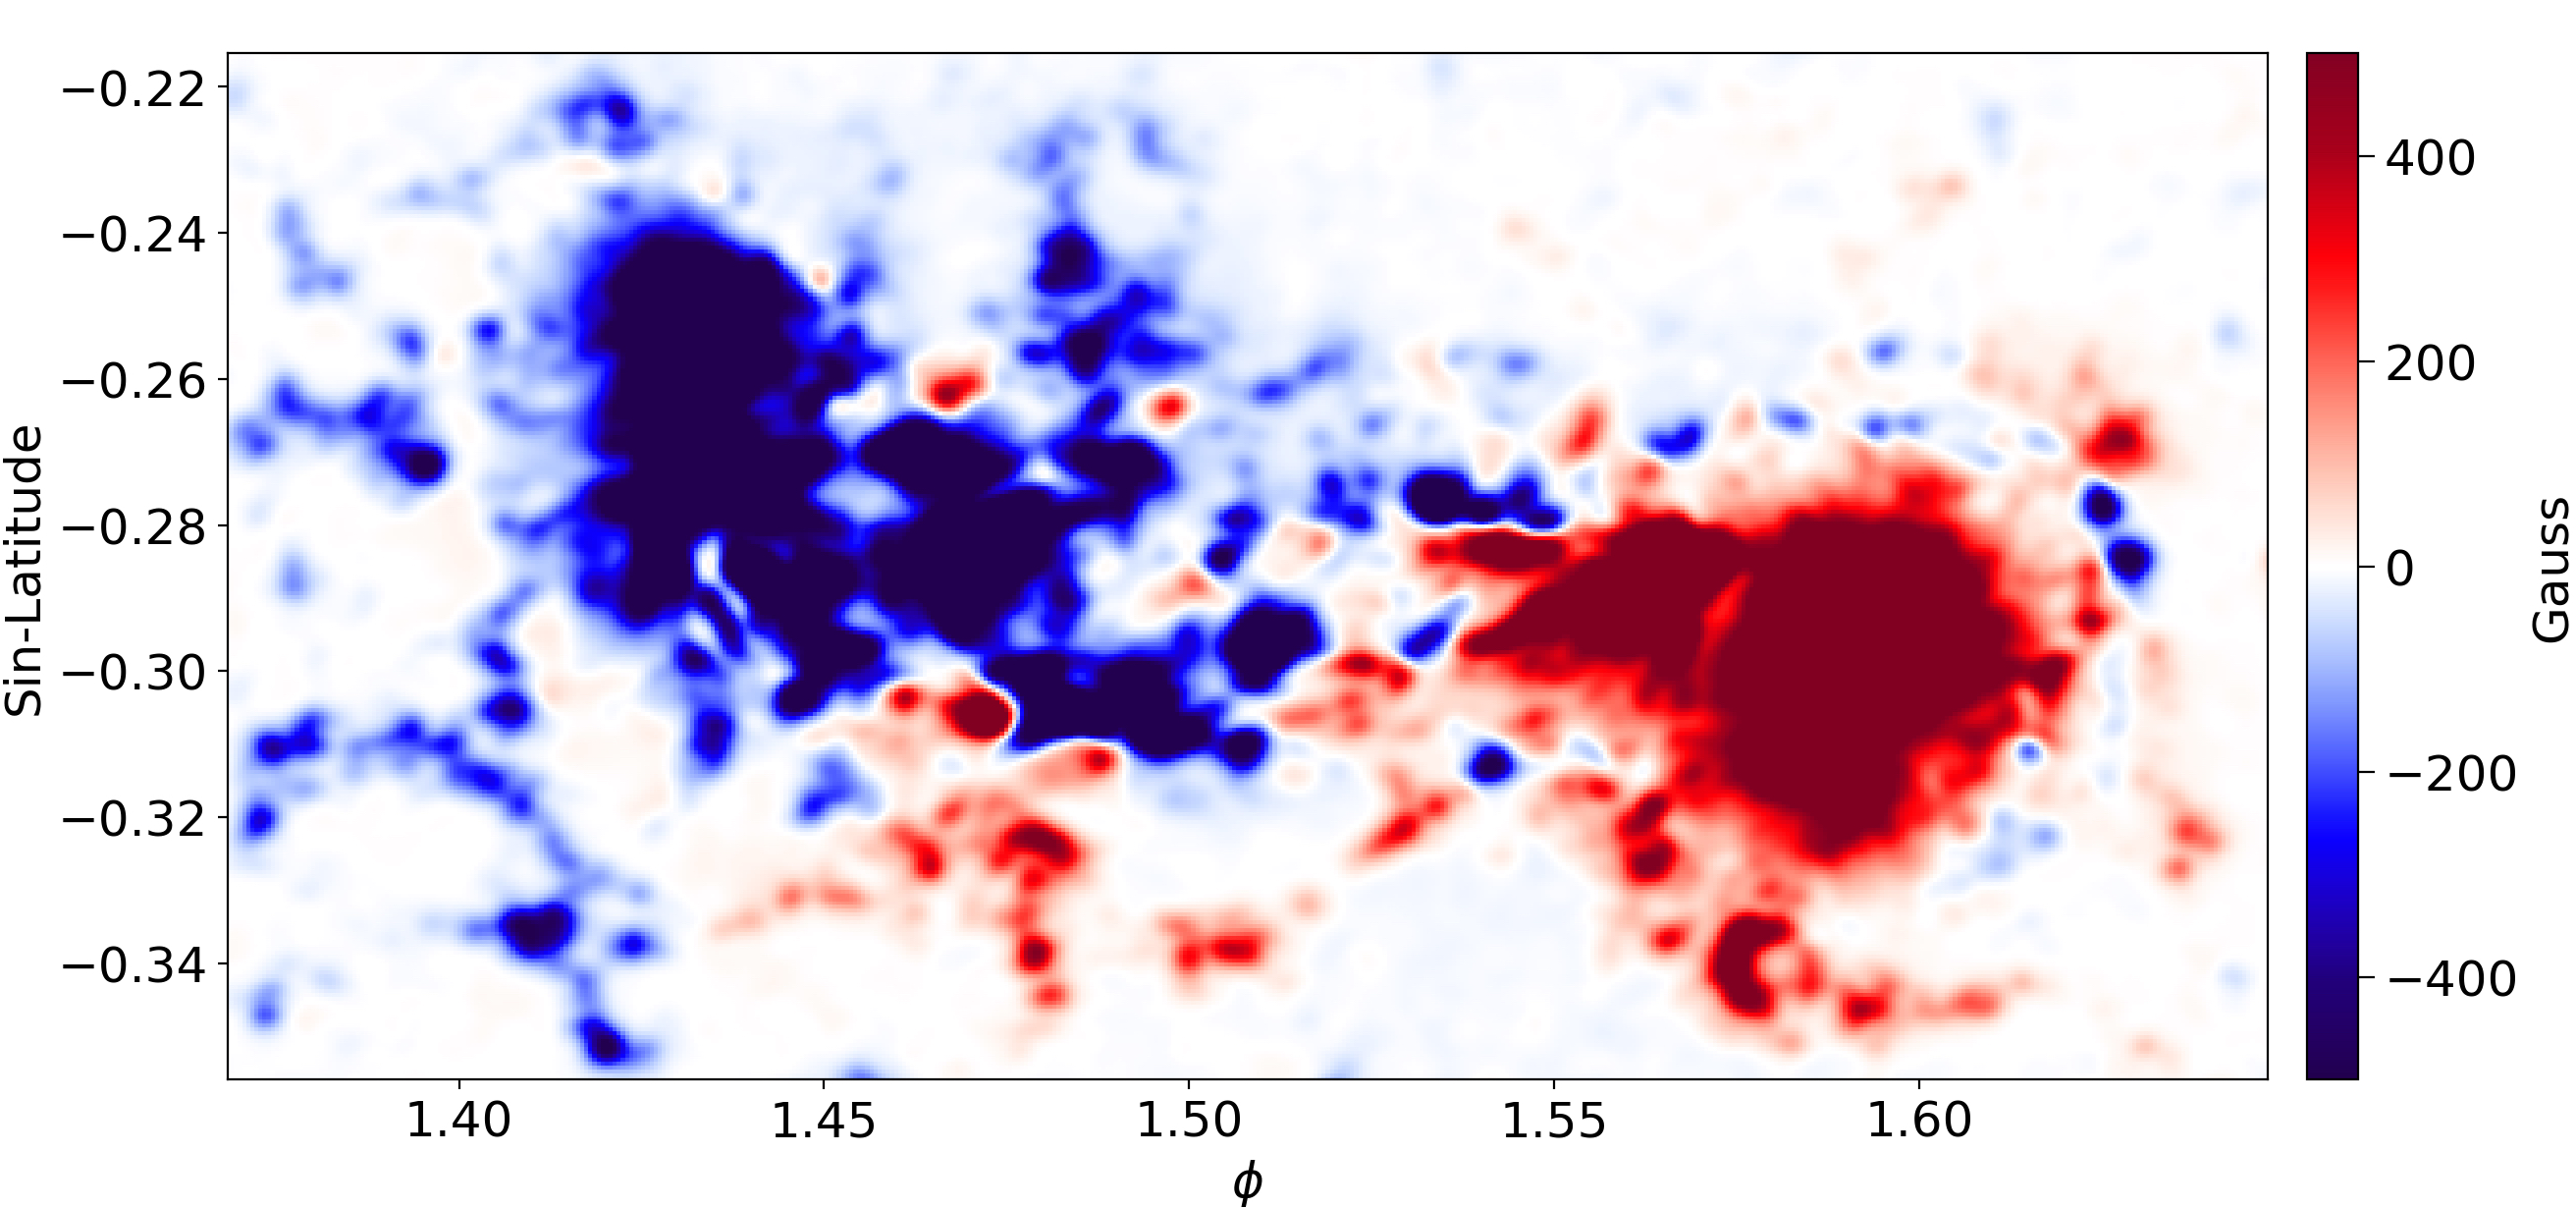